## Census Income - Final Report

In [1]:
# Loading packages
library(car)
library(tidyverse)
library(tidymodels)
library(broom)
library(glmnet)
library(leaps)
library(faraway)
library(mltools)

Loading required package: carData

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::recode() masks car::recode()
✖ purrr::some()   masks car::some()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.2.1     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────

## Introduction

Our team worked with the "Adult" dataset (https://archive.ics.uci.edu/dataset/2/adult), also called the "Census Income" dataset, which has been widely used for income prediction tasks in machine learning. It’s a public dataset, originally composed by the U.S. Census Bureau, and it’s available on the UCI Machine Learning Repository. The dataset was compiled to help classify whether a person’s income exceeds $50,000 per year based on demographic and work-related factors.

In the dataset, there are 48,842 individuals (observations) and 15 attributes (column variables) which include our target variable « income ». Since the dataset has more variables than we might need, a big part of this project will be exploring which variables are actually useful for predicting income. 

The response variable is:
- `income`: Binary label that indicates if a person earns more than \\$50,000 or less than/equal to \\$50,000.

The 14 input variables are:
- `age`: Age in years.
- `workclass`: Employment status of the individual.
- `fnlwgt`: Final weight of how race, sex,  country of origin factors in when it comes to predicting income.
- `education`: Highest degree of education attained.
- `education.num`: Education level in years.
- `marital.status`: Marital status of the individual.
- `occupation`: Type of occupation.
- `relationship`: Relationship status.
- `race`: Individual's race.
- `sex`: Gender.
- `capital.gain`: Capital gains in the past year (U.S. dollars).
- `capital.loss`: Capital losses in the past year (U.S. dollars).
- `hours.per.week`: Number of hours worked per week.
- `native.country`: Country of birth.

The continuous variables include `age`, `fnlwgt`, `education.num`, `capital.gain`, `capital.loss`, and `hours.per.week`. 

The categorical variables include `income`, `workclass`, `education`, `marital.status`, `occupation`, `relationship`, `race`, `sex`, and `native.country`.

According to Pew Research Center, on average, married men still tend to out-earn married women. Overall, husbands’ median earnings are higher than wives’ (\\$65,000 vs. \\$35,000 in 2022), making it more likely for men to surpass the \\$50,000 threshold. Even when marriages are structured to be more equal, wives’ median earnings (\\$60,000) nearly match husbands’ (\\$62,000), but in traditional “breadwinner husband” marriages, the gap is much larger (\\$96,000 for husbands vs. $30,000 for wives). While wives’ earnings have grown closer to their husbands’ over time, especially in egalitarian marriages, the evidence suggests that married men generally remain more likely than married women to earn above \\$50,000 (Fry et al., 2023).

**Questions**: Are married men more likely to earn above $50K than married women?

This question examines whether the combination of gender and marital status influences income level, focusing on the differences in income between married men and women. It is an inference question as we are finding the income difference between two levels of the input variable, gender. We would be comparing the proportion of men who earn over \\$50k, and the proportion of women who earn over \\$50k.

To answer this question using the above dataset, we need to filter all the married individuals, and select the relevant columns: `sex`, `marital.status`, and `income`. 

Then test if there are other explanatory variables that could answer our question, group the individuals by `sex` and graph to see the proportions of individuals of each group who earn above \\$50k.

## Methods And Results

### Exploratory Data Analysis (EDA)”

In [2]:
# load dataset
# Main developer: Lily
# Contributor: Manuella, Una, Kaiwei
data <- read_csv("adult.csv")

head(data, 10)

Rows: 32561 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): workclass, education, marital.status, occupation, relationship, rac...
dbl (6): age, fnlwgt, education.num, capital.gain, capital.loss, hours.per.week

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,<=50K


In [3]:
# check for any missing values
# Main developer: Lily
# Contributor: Manuella, Una, Kaiwei
missing_status <- sum(is.na(data$marital.status))
missing_status

missing_gender <- sum(is.na(data$sex))
missing_gender

missing_income <- sum(is.na(data$income))
missing_income

[1] 0

[1] 0

[1] 0

The step above checks that there are no missing values for each of the variables.

In [4]:
# Main developer: Lily
# Contributor: Manuella, Una, Kaiwei
data_filtered <- data %>%
    filter(marital.status == "Married-civ-spouse" | marital.status == "Married-AF-spouse" | marital.status == "Married-spouse-absent")

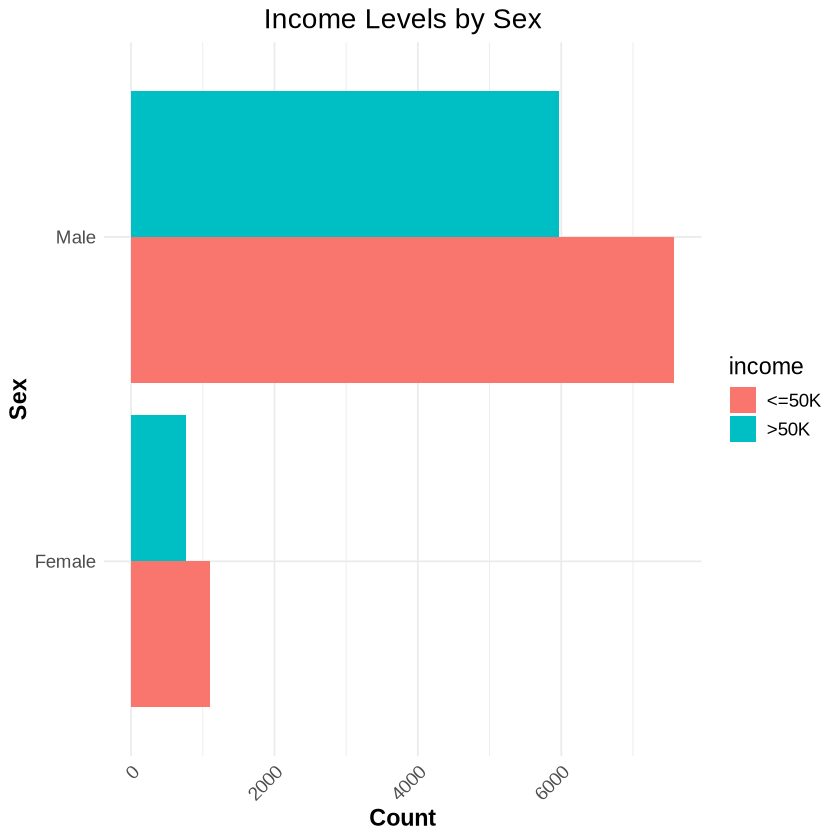

In [5]:
# Main developer: Lily, Una, Manuella, Kaiwei

sex_plot <- ggplot(data_filtered, aes(x = sex, fill = income)) +
  geom_bar(position = "dodge") +
  labs(
    title = "Income Levels by Sex",
    x = "Sex",
    y = "Count",
    fill = "income"
  ) +
  theme_minimal() +
  theme(
    text = element_text(size = 14),
    axis.title = element_text(face = "bold"),
    plot.title = element_text(hjust = 0.5),
    axis.text.x = element_text(angle = 45, hjust = 1)  # Rotate x-axis labels
  ) +
  coord_flip()

sex_plot

Bar plots are great for exploring explanatory variables. For example, we can create a bar plot to show the relationship between income and sex. This plot clearly illustrates the counts or proportions of people in each income category across different genders. Using stacked or grouped bar charts can help compare income distributions effectively and identify which gender is linked to higher income levels. Here we did not look at any other variables as they are not directly related to our question. However, we will use different methods throughout this project to find the explanatory variables most related to income level.

### “Methods: Plan”

A logistic regression model is used to answer whether married men are more likely to earn >50k than married women. This model is appropriate since the dependent variable `income` is binary, and the logistic model is used to estimate and test the true relation between different types of variables and a binary response. It can predict whether `income` is `>50K` or `<=50K` and also the probability of the binary responses. We are able to measure the likelihood of earning more than $50K for the two genders  with this probability. The logistic regression model allows us to include multiple independent input variables, which can eliminate any confounding effects that some variables may have. 

When using the logistic regression model, we assume that each observation in the dataset is independent. We also assume that there is a linear relationship between the explanatory and response variables. Third, multicollinearity should not exist in the logistic regression model, that is the independent input variables in the model are not highly correlated to one another. Multicollinearity can inflate standard errors which lead to unreliable estimates.

There are potential limitations/weaknesses in the logistic regression model. When we exclude input variables that are related to `income` but not related to the question to be answered, it could lead to biased estimates. For example, if we decide not to include `education.num` which significantly improves the goodness of fit of the model, we could overestimate the effect that gender has on `income`. In addition, the logistic regression may fail if the relation between variables is too complex. It assumes the input variables have additive effects on the response variable, and we would have to state the complex interactions between variables if they exist. Finally, if too many variables are included in the model, it would be overfitted.

In [6]:
# Main developer: Lily
# Contributor: Manuella, Una, Kaiwei
data_filtered <- data_filtered %>%
    mutate(income = ifelse(income == ">50K", 1, 0))

In [7]:
# Main developer: Lily
# Contributor: Manuella, Una, Kaiwei
log_model <- glm(income ~ sex, data = data_filtered, family = binomial)

summary(log_model)$coefficients

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-0.3599122,0.04692541,-7.669879,1.721583e-14
sexMale,0.1208359,0.05001634,2.415929,1.569512e-02


To determine whether other variables (eg. confounding variables) other than `sex` should be added to the regression model, we would perform a Likelihood Ratio Test. This would determine the goodness of fit of the simple model with only `sex` as the input variable and another model with multiple additive input variables, and it would be compared if adding multiple variables significantly improves the goodness of fit. 

In [8]:
# Main developer: Lily
# Contributor: Manuella, Una, Kaiwei
simple_log_model <- glm(income ~ sex, 
                        data = data_filtered, 
                        family = binomial)
simple_log_model_tidy <- tidy(simple_log_model, exponentiate = TRUE) %>% 
    mutate_if(is.numeric, round, 3)

two_log_model <- glm(income ~ sex + hours.per.week, 
                     data = data_filtered, 
                     family = binomial)
two_log_model_tidy <- tidy(two_log_model, exponentiate = TRUE) %>% 
    mutate_if(is.numeric, round, 3)

simple_log_model_tidy
two_log_model_tidy

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.698,0.047,-7.670,0.000
sexMale,1.128,0.050,2.416,0.016


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.246,0.073,-19.106,0.000
sexMale,0.923,0.052,-1.561,0.119
hours.per.week,1.029,0.001,18.795,0.000


In [9]:
# Computing the likelihood ratio test between a single additive input variable and two variables model to measure goodness of fit
# Main developer: Lily
# Contributor: Manuella, Una, Kaiwei
compare_result <- anova(simple_log_model, two_log_model, test = "LRT")

compare_result

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,15415,21120.60,NA,NA,NA
2,15414,20739.61,1,380.9931,7.563833e-85


After adding `hours.per.week` to the model, the estimate for `sexMale` changed from 0.1208 to -0.0807. This suggests that maybe men are more likely to earn over $50K because they are working more hours per week, making `hours.per.week` a confounding variable. Also, the analysis of the deviance table shows that the residual deviance decreased when `hours.per.week` is added, indicating that this variable significantly improves the model's fit.

Adding another variable to the model, `education.num`.

In [10]:
# Creating a three variables logistic model
# Main developer: Lily
# Contributor: Manuella, Una, Kaiwei
three_log_model <- glm(income ~ sex + hours.per.week + education.num, 
                       data = data_filtered, 
                       family = binomial)

three_log_model_tidy <- tidy(three_log_model, exponentiate = TRUE) %>% 
    mutate_if(is.numeric, round, 3)

two_log_model_tidy
three_log_model_tidy

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.246,0.073,-19.106,0.000
sexMale,0.923,0.052,-1.561,0.119
hours.per.week,1.029,0.001,18.795,0.000


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.007,0.116,-43.289,0.000
sexMale,0.960,0.056,-0.735,0.463
hours.per.week,1.024,0.002,15.243,0.000
education.num,1.431,0.008,44.704,0.000


In [11]:
# Computing the LRT between two and three additive variables model to measure goodness of fit
# Main developer: Lily
# Contributor: Manuella, Una, Kaiwei
compare_result <- anova(two_log_model, three_log_model, test = "LRT")

compare_result

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,15414,20739.61,NA,NA,NA
2,15413,18160.93,1,2578.671,0


Here, the residual deviance after adding `education.num` decreased, indicating that this variable significantly improves the model's fit.

Adding one more variable, `occupation`.

In [12]:
# Creating a four variables logistic model
# Main developer: Lily
# Contributor: Manuella, Una, Kaiwei
four_log_model <- glm(income ~ sex + hours.per.week + education.num + occupation, 
                      data = data_filtered, 
                      family = binomial)

four_log_model_tidy <- tidy(four_log_model, exponentiate = TRUE) %>% 
    mutate_if(is.numeric, round, 3)

three_log_model_tidy
four_log_model_tidy

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.007,0.116,-43.289,0.000
sexMale,0.960,0.056,-0.735,0.463
hours.per.week,1.024,0.002,15.243,0.000
education.num,1.431,0.008,44.704,0.000


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.011,0.150,-30.269,0.000
sexMale,0.983,0.061,-0.290,0.772
hours.per.week,1.023,0.002,13.518,0.000
education.num,1.311,0.009,29.003,0.000
occupationAdm-clerical,1.671,0.115,4.466,0.000
occupationArmed-Forces,1.020,1.297,0.015,0.988
occupationCraft-repair,1.332,0.106,2.708,0.007
occupationExec-managerial,3.233,0.106,11.048,0.000
occupationFarming-fishing,0.471,0.152,-4.961,0.000


In [13]:
# Computing the LRT between the three variables and four variables model to measure goodness of fit
# Main developer: Lily
# Contributor: Manuella, Una, Kaiwei
compare_result <- anova(three_log_model, four_log_model, test = "LRT")

compare_result

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,15413,18160.93,NA,NA,NA
2,15399,17436.78,14,724.1524,1.798895e-145


Here, the residual deviance after adding `occupation` decreased, indicating that this variable significantly improves the model's fit as well.

Looking at our last model with four input variables, it seems that `hours.per.week` and `occupation` may be interactive variables as occupations determine the hours worked per week.

For the two models:
- Null hypothesis: the interaction term (`hours.per.week * occupation`) does not improve the model's fit.
- Alternative hypothesis: the interaction term significantly improves the model's fit.

In [14]:
# Main developer: Lily
# Contributor: Manuella, Una, Kaiwei
# Changing four variable additive model to interactive model for two variables
four_log_model_interactive <- glm(income ~ sex + hours.per.week * occupation + education.num, 
                                  data = data_filtered, 
                                  family = binomial)


# Computing the LRT between the four additive variables and four interactive variables model to measure goodness of fit
compare_result <- anova(four_log_model, four_log_model_interactive, test = "LRT")

compare_result

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,15399,17436.78,NA,NA,NA
2,15385,17423.46,14,13.32115,0.5014068


Our result shows a p-value of 0.50, greater than a significance level of 0.05. Therefore, we fail to reject the null hypothesis in favour of the alternative hypothesis. This concludes that the interaction term (`hours.per.week * occupation`) does not improve the model's fit.

Thus, the model `four_log_model` with four additive variables would be our best fitted model.

In [15]:
four_log_model


Call:  glm(formula = income ~ sex + hours.per.week + education.num + 
    occupation, family = binomial, data = data_filtered)

Coefficients:
                (Intercept)                      sexMale  
                   -4.53291                     -0.01756  
             hours.per.week                education.num  
                    0.02275                      0.27071  
     occupationAdm-clerical       occupationArmed-Forces  
                    0.51372                      0.01984  
     occupationCraft-repair    occupationExec-managerial  
                    0.28675                      1.17327  
  occupationFarming-fishing  occupationHandlers-cleaners  
                   -0.75294                     -0.45971  
occupationMachine-op-inspct      occupationOther-service  
                    0.01643                     -0.69664  
  occupationPriv-house-serv     occupationProf-specialty  
                  -12.44325                      0.89149  
  occupationProtective-serv    

- $\hat{\beta}_1$ gives the changes in log odds per one-unit increase in X.

Since 1/0.983=1.0173, we estimate that the odds of income are higher for male individuals than female individuals while keeping the rest of the input variables constant.

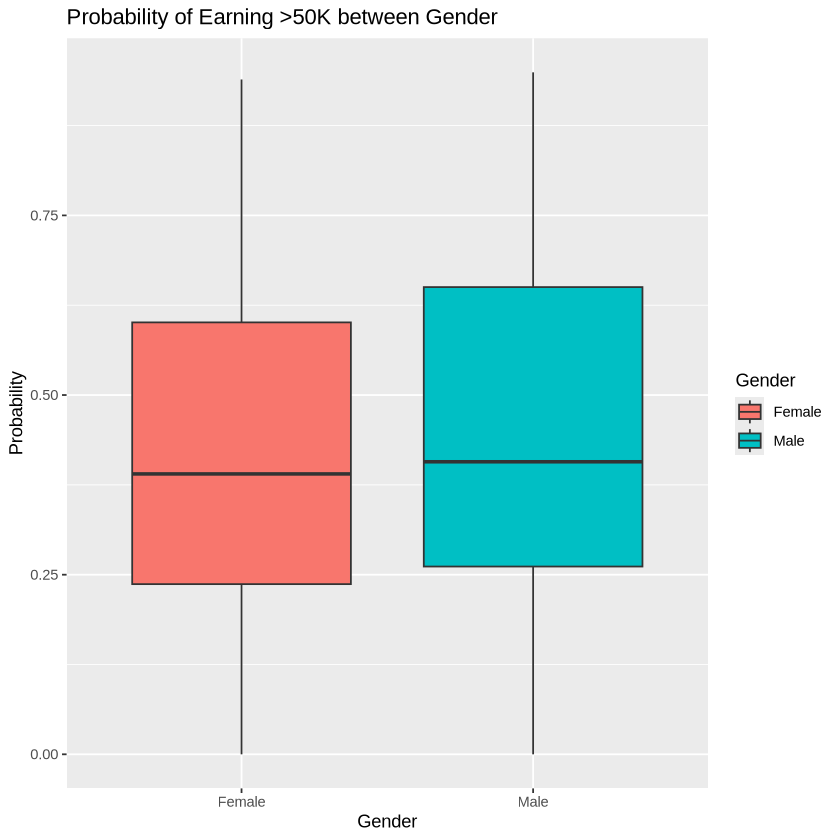

In [16]:
# Main developer: Lily
# Contributor: Manuella, Una, Kaiwei
# Create a visualization for estimated probabilities
predicted <- data_filtered %>%
  mutate(predicted_prob = predict(four_log_model, type = "response"))

ggplot(predicted, aes(x = sex, y = predicted_prob, fill = sex)) +
  geom_boxplot() +
  labs(
    title = "Probability of Earning >50K between Gender",
    x = "Gender",
    y = "Probability",
    fill = "Gender")

Looking at the boxplot above, it seems that the probability of married men earning over $50K is slightly higher than that of married women. This is the expected outcome from the planning stage with the final bar graph. However, the boxplots in this case overlap mostly at the same intervals of probability. This could be because many other variables may predict the income of individuals, and gender is not the most statistically important factor.

## Discussion

Our findings indicate that while male individuals showed slightly higher estimated probabilities of earning more than $50K, the difference between married men and married women was subtle and not as pronounced as we might have initially expected. The overlapping ranges in the boxplots suggest that gender alone is not a dominant predictor of income levels; many other factors, such as education, experience, and occupation type, likely play a more significant role. This outcome partially aligns with our initial expectations—while we did anticipate some gender-based disparities, the results illustrate the importance of considering a broader range of variables in the model.

To improve our model, we could incorporate additional predictors or refine the ones already included. For example, using interaction terms to capture how certain variables jointly influence income or testing non-linear transformations may help uncover more nuanced relationships. Additionally, collecting more comprehensive or higher-quality data, such as more detailed occupational categories or region-specific economic indicators, could further strengthen our analysis.

In terms of future research, this study opens up several avenues for inquiry. We could investigate how other demographic and socio-economic factors interact to determine income, explore changes over time to identify evolving labor market trends, or examine the effects of policy changes (e.g., minimum wage adjustments or family leave policies). Ultimately, our findings highlight the complexity of income determination and the need for multifaceted approaches to fully understand the driving forces behind earnings differences.

## References

Fry, R. (2023, April 13). In a growing share of U.S. marriages, husbands and wives earn about the same. Pew Research Center. https://www.pewresearch.org/social-trends/2023/04/13/in-a-growing-share-of-u-s-marriages-husbands-and-wives-earn-about-the-same/ 

Vandenbroucke, G. (2018). Married men sit atop the wage ladder. Economic Synopses, 2018(24). https://doi.org/10.20955/es.2018.24 